In [130]:
# preamble

import os
import sys
import matplotlib.pyplot as plt
import pdb
import numpy as np
from scipy.integrate import solve_ivp
from scipy.special import erfc, erf
import pandas as pd
from matplotlib import ticker
import scipy as sp
from scipy.integrate import cumulative_trapezoid, trapezoid, odeint, solve_bvp, solve_ivp
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colormaps
import matplotlib.ticker as mtick
from matplotlib.ticker import LogLocator, FuncFormatter, NullFormatter, FixedLocator, StrMethodFormatter, LogFormatter, LogFormatterSciNotation, LogFormatterExponent, LogFormatterMathtext, MaxNLocator, MultipleLocator
from matplotlib.lines import lineStyles
import cmocean
import cmocean.cm as cmo
from matplotlib.colors import LogNorm
from IPython.display import clear_output
import matplotlib.patheffects as pe
from matplotlib.collections import LineCollection
from labellines import labelLines

def sci_fmt(x):
    if x == 0 or not np.isfinite(x):
        return "0"
    exp = int(np.floor(np.log10(abs(x))))
    mant = x / (10**exp)
    # round mantissa to integer as you requested
    return rf"{mant:.0f}$×10^{{exp}}$"

# constants

beta = 4e-10 # Pa-1, compressibility at ~273.15 K
rhow = 1025 # kg m-3
rhoi = 916 # kg m-3
delta_rho = rhow - rhoi # kg m-3
Cp = 4.2e3 # J kg-1 K, water
kappa = 0.143e-6 # thermal diffusivity (m2/s)
k = 0.61 # thermal conductivity (W/m K)
λ = 0.65 # thermodynamic parameter of ice (adimensional)
g = 1.315 # m/s2
nu = 0.3 # Poisson's ratio
E = 5e9 # Pa, Young's modulus
G = 3.3e9 # Pa, shear modulus from Berne et al., 2023
m = G / (1 - nu)
eta_w = 1e-3 # Pa s, viscosity of water
L = 334e3 # J/kg, latent heat of fusion
c = 2e3 # J kg-1 K-1, specific heat capacity of ice at ~100 K

# tensile strength
S = 1e6 # Pa, tensile strength of ice
Kc = 1e6 # Pa m1/2, fracture toughness of ice

# depth params
ymi = 1 # m, initial ice shell thickness
R = 1.5608e6 # m, radius of Europa
rc = 1.4608e6 # m, radius to top of silicate component
rii = R - ymi # m, initial radius of ice shell base
ri_timed = np.zeros((1,2)) # m, radii of ice shell base
ri_timed[0,0] = 0
ri_timed[0] = [rii, 0]
dzi = (ymi)/61
dti = 0.1*((0.1*(dzi**2))/kappa)

## time params
y2sec = 3.1536e7 # s/yr
tend = 5e6*y2sec # end time (s)
t = ((ymi/(2*λ))**2)/kappa # starting time (s)
n = 0 # first iteration


From Turcotte & Schubert 

If at $t=t_s$, all liquid in the dike is solidified, we can write

### $t_s = \frac{w^2}{4\kappa \lambda^2_2}$




Stefan #
### $ St_L=\frac{c_L \Delta T_L}{L} $

### $ \lambda \text{e}^{\lambda^2} \text{erf}(\lambda) = \frac{St_L}{\sqrt{\pi}}$

In [209]:
# determining the λ constant with Neumann
St = c * 170 / L
LHS = St / (np.pi**(1/2))
for l in np.linspace(0.01, 2, 1000):
    RHS = l * erf(l) * np.exp(l**2)
    if RHS == LHS or abs(RHS - LHS) < 0.007:
        clear_output(wait=False)
        lambda_2_sol_1 = l
        print(f"SUCCESS... λ = {lambda_2_sol_1:.5f}")
        break
    else:
        clear_output(wait=False)
        print(f"*loud buzzer* λ = {l:.3f}")
print(f"LHS - RHS = {LHS - RHS:.5f}")

SUCCESS... λ = 0.62154
LHS - RHS = 0.00671


In [208]:
# determining the λ constant with T&S eq 1.149
LHS = L * np.pi**(1/2) / (Cp * 170)
for l in np.linspace(0.01, 2, 100):
    RHS = np.exp(-l**2) /( l * (1 + erf(l)) )
    if RHS == LHS or abs(RHS - LHS) < 0.07:
        clear_output(wait=False)
        lambda_2_sol_2 = l
        print(f"SUCCESS... λ = {lambda_2_sol_2:.3f}")
        break
    else:
        clear_output(wait=False)
        print(f"*loud buzzer* λ = {l:.3f}")
print(f"LHS - RHS = {LHS - RHS:.5f}")

SUCCESS... λ = 0.553
LHS - RHS = -0.02226


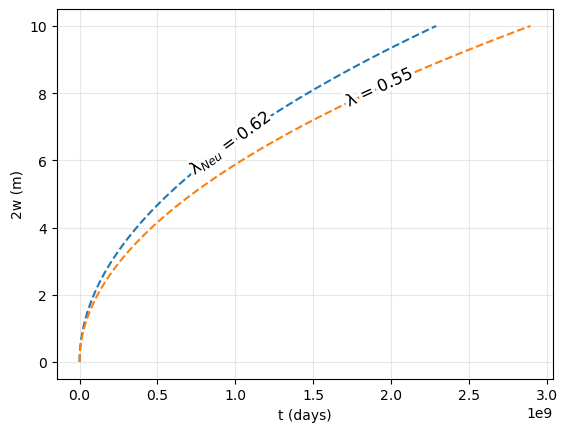

In [210]:
# timescale of closure

w = np.linspace(1e-3, 5, 100) # m, half-widths

t_close_1 = w**2 / ((4 * kappa * lambda_2_sol_1)**2)
t_close_2 = w**2 / ((4 * kappa * lambda_2_sol_2)**2)

fig, ax = plt.subplots()
ax.plot(t_close_1/(60*60*24), 2*w, linestyle = 'dashed', label=f'λ$_{{Neu}}$ = {lambda_2_sol_1:.2f}')
ax.plot(t_close_2/(60*60*24), 2*w, linestyle = 'dashed', label=f'λ = {lambda_2_sol_2:.2f}')
labelLines(ax.get_lines(), align=True, fontsize=12, color='black')
ax.set_ylabel('2w (m)')
ax.set_xlabel('t (days)')
ax.grid(which='both', alpha=0.3)
# ax.legend()
# plt.title(f"For λ$_2$ = {lambda_2_sol_1:.2f} and {lambda_2_sol_2:.2f}")


### $\frac{dy_m}{dt} = -\lambda_2 \left(\frac{\kappa}{t}\right)^{\frac{1}{2}}$
(eq. 4.147)

### $ \left(\frac{dT}{dy}\right)_{y=y_m}=\frac{-(T_m-T_0)}{\sqrt{\pi \kappa t}}\frac{\text{e}^{-\lambda_2^2}}{\lambda_2(1+\text{erf}\lambda_2)}$
(eq. 4.148)
<font color = 'darkyellow'>
## $ \frac{L\sqrt{\pi}}{c(T_m-T_0)}=\frac{\text{e}^{-\lambda_2^2}}{\lambda_2(1+\text{erf}\lambda_2)}$ </font>
(eq. 4.149)

### $\rho L \frac{dy_m}{dt}= k\left(\frac{dT}{dy}\right)_{y=y_m}$
(eq. 4.138)

#### Could you rewrite as this:

### $\left(\frac{dT}{dy}\right)_{y=y_m} = \frac{\rho L \frac{dy_m}{dt}}{k}$

In [94]:
LHS = L * np.sqrt(np.pi) / (c* (270 - 100))
LHS

3482.35050707319

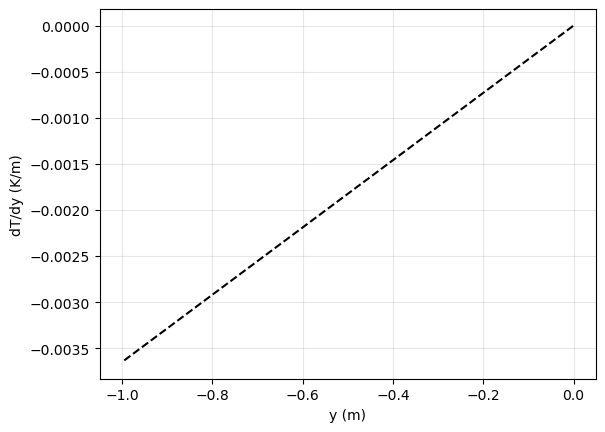

In [ ]:
dthdh = np.exp(-lambda_2_sol**2) / (lambda_2_sol * (1 + erf(lambda_2_sol)))
dhdy = - (270 - 100) / np.sqrt(np.pi * kappa * t_close)
dTdy = dthdh / dhdy

dymdt = - lambda_2_sol * np.sqrt(kappa / t_close)
dTdym = rhow * L * dymdt / k
y = -(2 * lambda_2_sol * np.sqrt(kappa * t_close))

plt.figure()
plt.plot(y, dTdy, color = 'black', linestyle = 'dashed')
plt.ylabel('dT/dy (K/m)')
plt.xlabel('y (m)')
plt.grid(which='both', alpha=0.3)


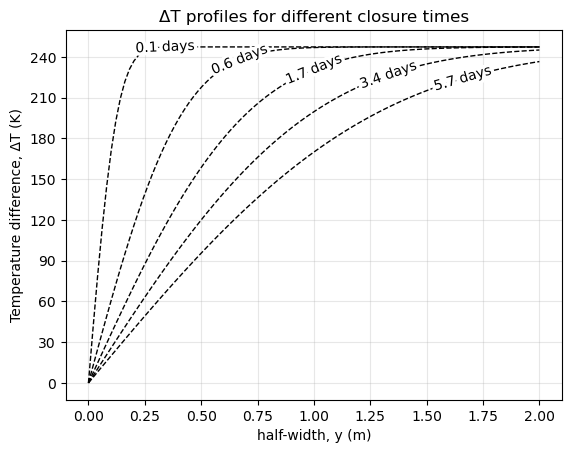

In [193]:
# T - T0 vs y
T0 = 100
Tm = 270

w = np.linspace(1e-1, 1, 5)
times = w**2 / (4 * kappa * lambda_2_sol**2) 
dT = []

plt.figure()
for t in times:
    ym = 2 * lambda_2_sol * np.sqrt(kappa * t)
    y = np.linspace(0, 2, 100)
    eta = y / (2 * np.sqrt(kappa * t))
    dT_ = (Tm - T0) * erf(eta) / erf(lambda_2_sol)
    dT.append(dT_)
    plt.plot(y, dT_, label=f"{t/(60*60*24):.1f} days", color = 'black', ls = 'dashed', lw = 1 )

labelLines(plt.gca().get_lines(), align=True, fontsize=10)
plt.xlabel("half-width, y (m)")
plt.ylabel("Temperature difference, ΔT (K)")
plt.grid(which="both", alpha=0.3)
# plt.legend(title="Times")
plt.title(f"ΔΤ profiles for different closure times")
ax = plt.gca()
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))


Text(0.5, 1.0, 'T profiles for different closure times')

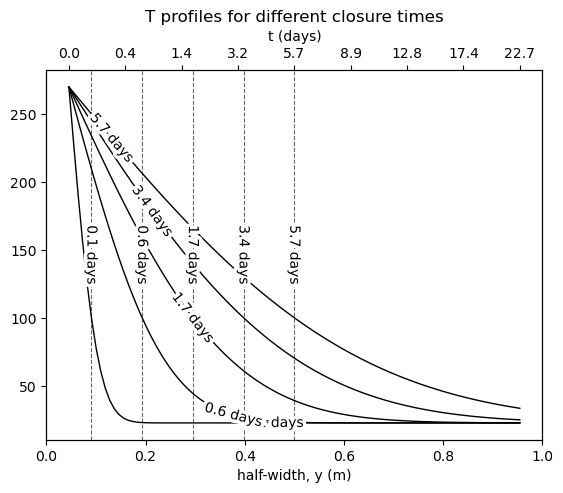

In [252]:
# Temperature prof

T0, Tm = 100, 270
w = np.linspace(1e-1, 1, 5)
times = w**2 / (4 * kappa * lambda_2_sol**2)
profiles = []

fig, ax = plt.subplots()
ax2 = ax.twiny()

for t in times:
    ym = 2 * lambda_2_sol * np.sqrt(kappa * t)
    y = np.linspace(0, 2, 100)
    eta = y / (2 * np.sqrt(kappa * t))
    T = Tm - (Tm - T0) * erf(eta) / erf(lambda_2_sol)
    plt.plot(y, T, label=f"{t/(60*60*24):.1f} days", color = 'black', ls = 'solid', lw = 1 )   
    ax2.axvline(ym, color='black', lw=0.8, alpha=0.6, ls = "dashed", label = f"{t/(60*60*24):.1f} days")
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{(y**2 / (4 * kappa * lambda_2_sol**2))/(60*60*24):.1f}'))

labelLines(plt.gca().get_lines(), align=True, fontsize=10)
ax2.set_xlabel("t (days)")
ax.set_xlabel("half-width, y (m)")
plt.ylabel("Temperature, T (K)")
# ax2.grid(alpha=0.3)
plt.title("T profiles for different closure times")

Text(0.5, 1.0, 'T profiles for different closure times')

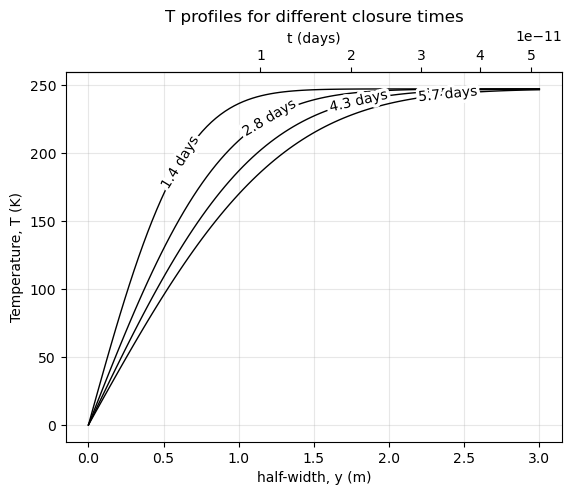

In [ ]:
fig, ax = plt.subplots()

for t in times:
    ym = 2 * lambda_2_sol * np.sqrt(kappa * t)
    y = np.linspace(0, 2, 100)
    eta = y / (2 * np.sqrt(kappa * t))
    T = Tm - (Tm - T0) * erf(eta) / erf(lambda_2_sol)
    plt.plot(y, T, label=f"{t/(60*60*24):.1f} days", color='black', ls='solid', lw=1)

labelLines(plt.gca().get_lines(), align=True, fontsize=10)
secax.set_xlabel("t (days)")
ax.set_xlabel("half-width, y (m)")
plt.ylabel("Temperature, T (K)")
plt.grid(which="both", alpha=0.3)
plt.title("T profiles for different closure times")